#  🤖 Static Agentic RAG with CodeGen

Users can at times expect an AI application to understand their queries, even if they are vague and contain embedded semantic logic, such as a short form query that is actually compound in nature.  There is no explicit breakdown of all subqueries, because domain experts generally understand what is meant by the short form query.  In production, this is a challenging task for an AI model to handle, as foundation models are generally trained on internet scale information, which is not gauranteed to contain domain specific logic.  In fact, this kind of logic could even be harmful for generalization, as the langugage would not make much sense with respect to other contexts.  

Queries, even if clear, may be compound in nature and may require subquery decomposition for targeted QA using paradigms/techniques such as RAG.  This in turn may also necessitate the need for: reranking, vectorstore filtering for initial entity-aware document retrieval to remove/prevent noise, aggregation, etc.

Furthermore, compound queries may be comparitive in nature and may require mathematical operations, which may require the use of a code generation model to generate the code for the mathematical operations.  Alternatively, agents with tools/libraries that can handle such operations can be used, which will add more determinism, and hopefully reliability.  

Note that the longer and more complex the agentic pipeline, the more the possibilities for cumulative errors to come up, and so development and maintenance may become difficult to scale across edge cases.  If this is the case, it may be preferable to move to a dynamic, human in the loop type of system. That route has its own unique challenges, such as robust routing and team setups.  A simple example can be found here: [Corrective RAG team](./../../agent_workflows/notebooks/corrective_rag_team.ipynb).

In [1]:
import os
import sys
from langchain_community.vectorstores import Chroma
from IPython.display import display, Markdown

current_dir = os.getcwd()
kit_dir = os.path.abspath(os.path.join(current_dir, ".."))
repo_dir = os.path.abspath(os.path.join(kit_dir, ".."))

sys.path.append(kit_dir)
sys.path.append(repo_dir)

from enterprise_knowledge_retriever.src.document_retrieval import DocumentRetrieval
from utils.agents.static_RAG_with_coding import CodeRAG

examples = []

CONFIG_PATH = os.path.join(kit_dir, "config.yaml")

/Users/codym/CAP/aisk_forked/ai-starter-kit/agent_env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load the embedding model for semantic search

We will use our DocumentRetrieval class to load the embedding model and vectorstore.  We import this from the enterprise knowledge retrieval package for reuse.  Depending on your needs, you can choose between "sambastudio" or "cpu" for embeddings acceleration.  At present, only the E5 large v2 model is supported.

In [2]:
documentRetrieval = DocumentRetrieval()
*_, embedding_model_info, retrieval_info, _ = documentRetrieval.get_config_info()
embeddings = documentRetrieval.load_embedding_model()

2024-08-01 12:33:57,390 [INFO] - Load pretrained SentenceTransformer: intfloat/e5-large-v2


load INSTRUCTOR_Transformer


2024-08-01 12:33:58,236 [INFO] - Use pytorch device: cpu


max_seq_length  512


## Load the vectorstore for use as a base database

In [3]:
vectorstore = Chroma(
    persist_directory=kit_dir
    + "/data/uber_lyft.chromadb",
    embedding_function=embeddings,
)

/Users/codym/CAP/aisk_forked/ai-starter-kit/agent_env/lib/python3.11/site-packages/langchain_core/_api/deprecation.py:139: LangChainDeprecationWarning: The class `Chroma` was deprecated in LangChain 0.2.9 and will be removed in 0.4. An updated version of the class exists in the langchain-chroma package and should be used instead. To use it run `pip install -U langchain-chroma` and import as `from langchain_chroma import Chroma`.
  warn_deprecated(
2024-08-01 12:33:58,634 [INFO] - Anonymized telemetry enabled. See                     https://docs.trychroma.com/telemetry for more information.


## Load the CodeRAG static agent pipeline

We are going to answer very complex, compound questions.  Numerous components will be used for both RAG [RagComponents](./../../utils/rag/rag_components.py), which inherits methods from [BaseComponents](./../../utils/rag/base_components.py).  [CodegenComponents](./../../utils/code_gen/codegen_components.py) will also be used.  For conciseness, components will not be listed in code here, but the links should route to the respective files/modules.  

The long, CodeRAG pipeline will be explained here.  

First, we need to define the state that will be required for this large-scale question-answering task:

    class CodeRAGGraphState(TypedDict):
    """
    A typed dictionary representing the state of a CodeRAG graph.

    Args:
        question: The user's question.
        subquestions: A list of subquestions, typically generated by a LLM agent.
        entities: A list of entities determined by a LLM agent.
        generation: The most recent generation from a LLM, which may include code generation.
        documents: A list of documents that were retrieved from the vectorstore and passed retrieval grading filtering.
        answers: A list of answers that have been accumulated from the pipeline.
        original_question: The original question, which may be needed if subquestions were generated, etc.
        code: The generated code from a LLM agent.
        runnable: A binary flag of "executed" or "exception", depending on if code exeution succeeded or not.
        error: The error message from an exception if any occurred.
        rag_counter: The RAG counter.
        code_counter: The code counter, which is used for maximum amount of retries after catching exceptions.
        examples: A list of examples for query reformulation.
    """

    question : str
    subquestions: List[str]
    entities: List[str]
    generation : str
    documents : List[str]
    answers: List[str] 
    original_question: str 
    code: str
    runnable: str
    error: str
    rag_counter: int
    code_counter: int
    examples: Optional[list]

We will need state for the question, subquestions (that will be proposed by an agent), entities (that will be determined from an agent), generation (the response that is generated at various points of the pipeline), documents (the documents that are retrieved from the vectorstore), answers (the accumulated answers that are provided if subqueries were generated for answering), original_question (logging the original question in case of subquery generation and answering), code (the code that is generated by the codegen agent), runnable (the runnable code flag - executed or exception, that is generated by the agents), error (an exception message after running the Python REPL tool), rag_counter (the counter for the RAG agents), code_counter (the counter for the code generation agents), and examples (provided for the prompt reformulation, if needed).

Next, we will add the nodes for all the components we will need for th graph (excluding components to be used for conditional edges):

def create_rag_nodes(self) -> StateGraph:
        """
        Creates the nodes for the CodeRAG graph state.

        Args:
            None

        Returns:
            The StateGraph object containing the nodes for the CodeRAG graph state.
        """

        workflow: StateGraph = StateGraph(CodeRAGGraphState)

        # Define the nodes
        workflow.add_node("initialize_code_rag", self.initialize_code_rag)
        workflow.add_node("reformulate_query", self.reformulate_query)
        workflow.add_node("get_new_query", self.pass_state)
        workflow.add_node("generate_subquestions", self.generate_subquestions)
        workflow.add_node("detect_entities", self.detect_entities)
        workflow.add_node("retrieve", self.retrieve_w_filtering)
        workflow.add_node("grade_documents", self.grade_documents)
        workflow.add_node("generate", self.rag_generate)
        workflow.add_node("pass_from_qa", self.pass_state)
        workflow.add_node("pass_to_codegen", self.pass_to_codegen)
        workflow.add_node("code_generation", self.code_generation)
        workflow.add_node("determine_runnable_code", self.determine_runnable_code)
        workflow.add_node("refactor_code", self.refactor_code)
        workflow.add_node("code_error_msg", self.code_error_msg)
        workflow.add_node("failure_msg", self.failure_msg)
        workflow.add_node("aggregate_answers", self.aggregate_answers)
        workflow.add_node("return_final_answer", self.final_answer)

        return workflow


Now we will need to setup the edges and conditional edges of the graph for our apps conrtol flow:


    def build_rag_graph(self, workflow: StateGraph) -> object:
        """
        Builds a graph for the RAG workflow.

        This method constructs a workflow graph that represents the sequence of tasks
        performed by the RAG system. The graph is used to execute the workflow and
        generate code.

        Args:
            workflow: The workflow object (StateGraph containing nodes) to be modified.

        Returns:
            The compiled application object for static CodeRAG
        """

        # Build graph

        checkpointer: MemorySaver = MemorySaver()

        workflow.set_entry_point("initialize_code_rag")
        workflow.add_conditional_edges(
            "initialize_code_rag",
            self.use_examples,
            {
                "answer_generation": "get_new_query",
                "example_selection": "reformulate_query",
            },
        )
        workflow.add_edge("reformulate_query", "get_new_query")
        workflow.add_conditional_edges(
            "get_new_query",
            self.route_question,
            {
                "answer_generation": "detect_entities",
                "subquery_generation": "generate_subquestions",
            },
        )
        workflow.add_edge("generate_subquestions", "detect_entities")
        workflow.add_edge("detect_entities", "retrieve")
        workflow.add_edge("retrieve", "grade_documents")
        workflow.add_edge("grade_documents", "generate")
        workflow.add_conditional_edges(
            "generate",
            self.check_hallucinations,
            {
                "not supported": "failure_msg",
                "useful": "pass_from_qa",
                "not useful": "failure_msg",
            }
        )
        workflow.add_edge("failure_msg", "pass_from_qa")
        workflow.add_conditional_edges(
            "pass_from_qa", 
            self.determine_cont, 
            {
                "continue": "pass_to_codegen",
                "iterate": "detect_entities",
            },
        )
        workflow.add_conditional_edges(
            "pass_to_codegen",
            self.route_question_to_code,
            {
                "llm": "aggregate_answers",
                "codegen": "code_generation",
            },
        )
        workflow.add_edge("code_generation", "determine_runnable_code")
        workflow.add_conditional_edges(
        "determine_runnable_code",
        self.decide_to_refactor,
        {
            "executed": "return_final_answer", 
            "exception": "refactor_code",
            "unsuccessful": "code_error_msg"
        },
        )
        workflow.add_edge("refactor_code", "determine_runnable_code")
        workflow.add_edge("code_error_msg", "return_final_answer")
        workflow.add_edge("aggregate_answers", "return_final_answer")
        workflow.add_edge("return_final_answer", END)

        app: CompiledGraph = workflow.compile(checkpointer=checkpointer)

        return app

*Note that conditional edges come from components methods, but are not instantiated as nodes.  They are internal routers and are only used as connectors between other nodes*

In [4]:
# add a config
config = {"configurable": {"thread_id": "1234"}}

# instantiate rag
rag = CodeRAG(
    configs=CONFIG_PATH,
    embeddings=embeddings,
    vectorstore=vectorstore,
    examples=examples,
)

# Initialize chains
rag.initialize()

# Build nodes
workflow = rag.create_rag_nodes()
print(workflow)

# Build graph
app = rag.build_rag_graph(workflow)

We have built this complex application.  Now let's visualize the graph and then have a discussion about different scenarios and how they may play out, if routed correctly via the agent system prompts.

2024-08-01 12:34:01,774 [INFO] - Browser listening on: ws://127.0.0.1:63643/devtools/browser/c948fcc5-ec4e-47bd-8248-874ac5fa9bf4
2024-08-01 12:34:05,386 [INFO] - terminate chrome process...



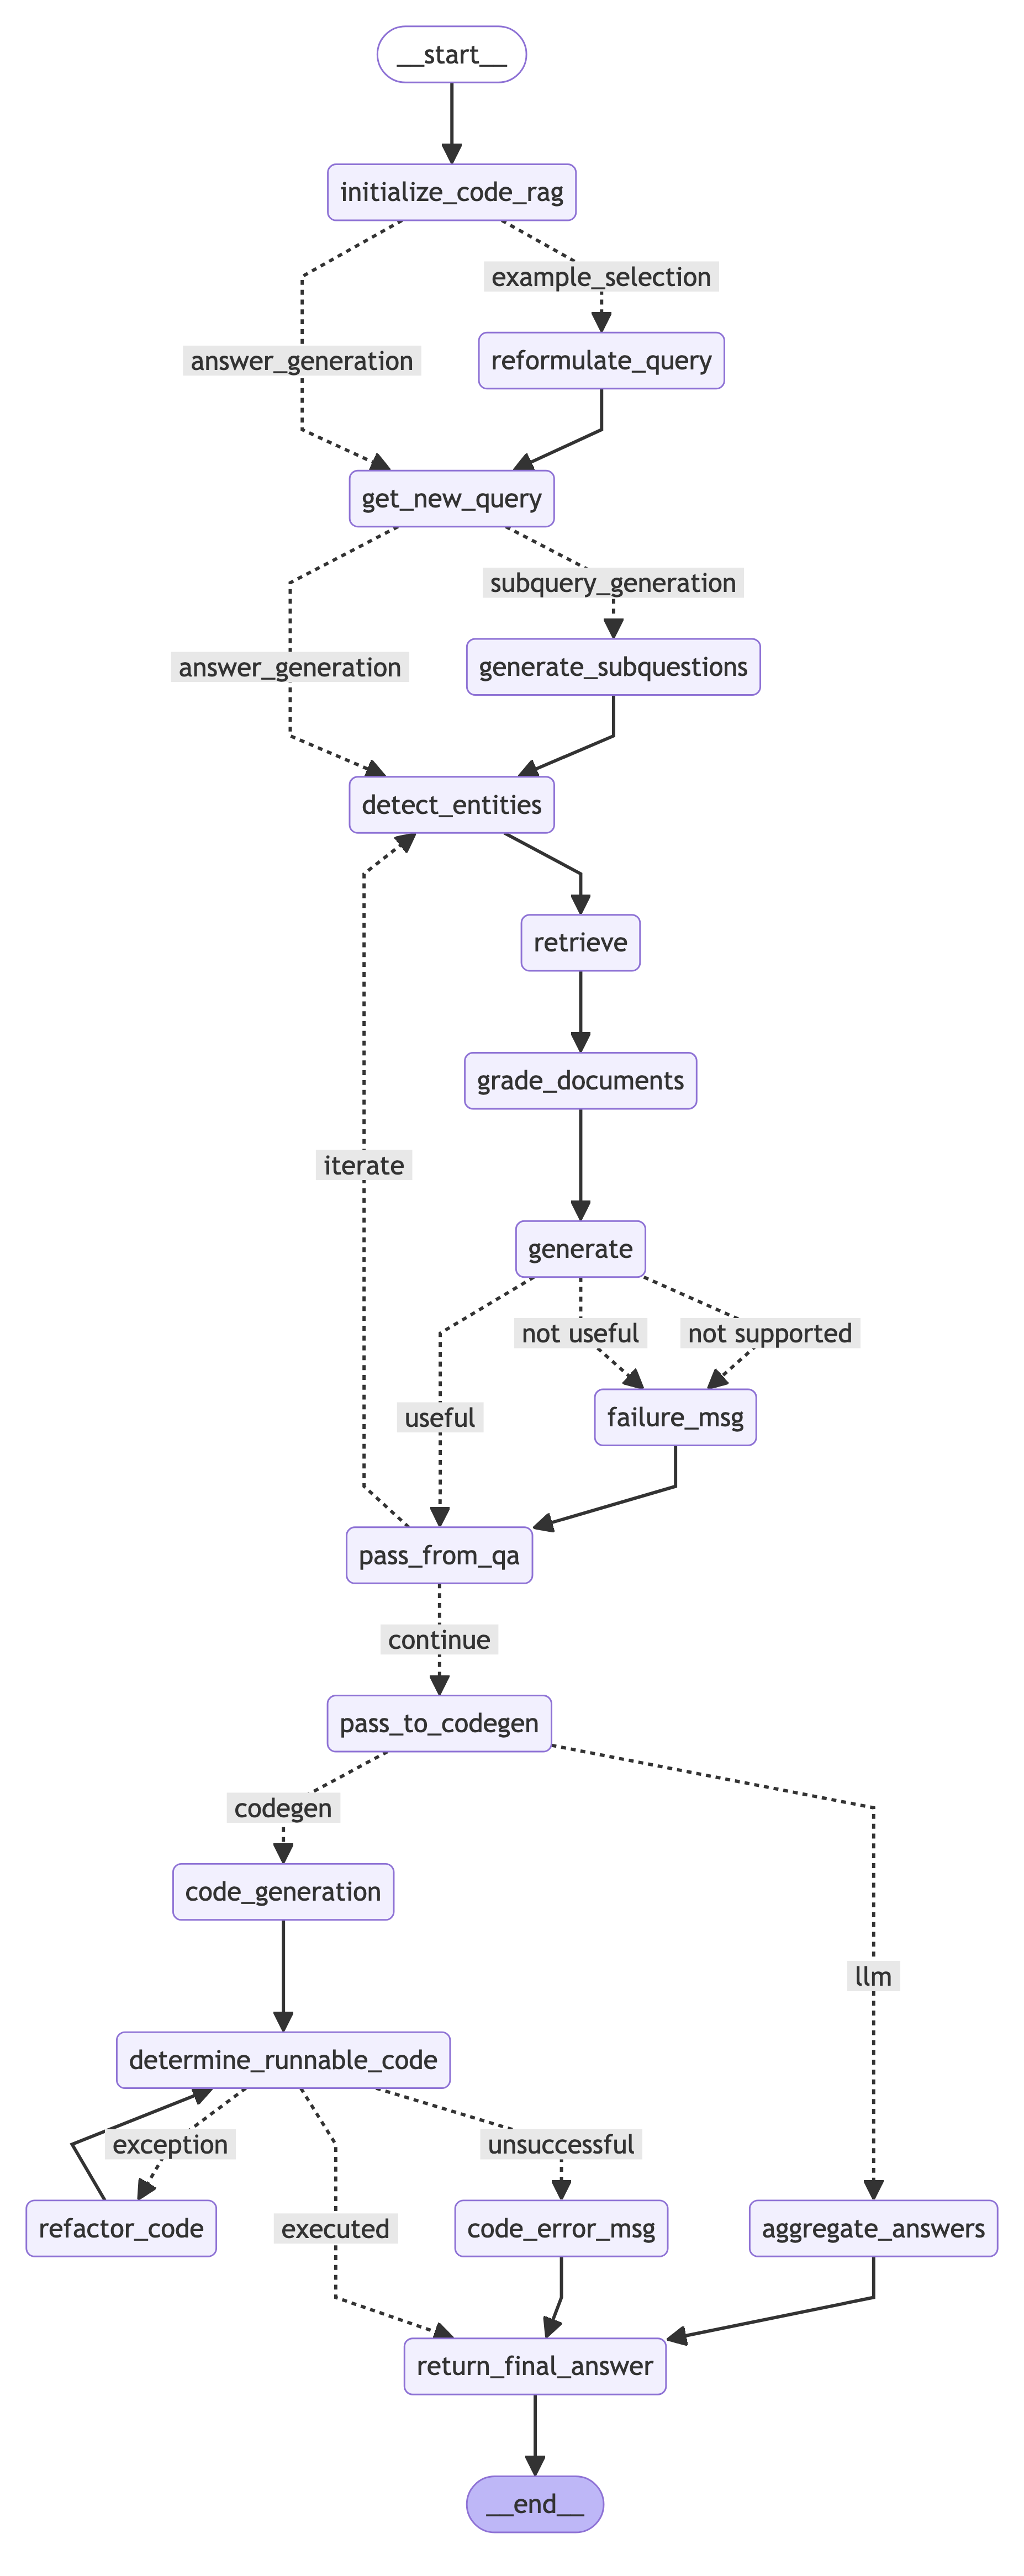

In [5]:
rag.display_graph(app)

## Description of pipeline

This complicated pipeline should demonstrate how seemingly straight forward user queries can require more and more complexity, which in turn means more optimization of agent system prompts, implementations for edge cases, etc.  It is recommended to start developing RAG systems for simple cases along with users and scale up complexity when really needed for user experience.  At some point, there will need to be a tradeoff between user experience/ease of use, latency (long chains will incur more and more calls to LLMs), and development challenges.

### Flow:

After initializing some counters to keep track of coding attempts, etc. The user query encounters the first conditional edge, which is an agent judge that determines, based on the [example router](./../../prompt_engineering/prompts/llama3_8b-prompt_engineering-example_judge.yaml) prompt, if the query needs reformulation or not.  If reformulation is needed, the judge determines the response to be "example selection".  Example selection routes to the reformulate query node. This node calls the reformulate_query method from the RAGComponents class.  This method calls the get_example_selector method to create a retriever for the examples.  After the retriever is instantiated, the get_examples method is called to obtain examples, based on the similarity of the example queries and the user query.  Each example contains a key value pair, which is the expected user query to be reformulated and the reformulated query.  A reformulation chain with the system prompt: [query reformulation](./../../prompt_engineering/prompts/llama3_8b-prompt_engineering-query_reformulation.yaml).  If no reformulation is needed, then the query simply passes to the next node, get_new_query, which is essentially just a pass through node that exists so we can connect a conditional edge to it (conditional edges need to be connected to nodes, not other edges).  

The next conditional edge is another agent judge.  This agent determines if the query is compound in nature and requires query decomposition, via its system prompt [subquery router](./../../prompt_engineering/prompts/llama3_8b-prompt_engineering-subquery_router.yaml).  If subquery generation is required, the query is then routed to the generate subquestions node.  This node calls the generate_subquestion method from RAGComponents, which obtains the question from the current state and passes it to the subquery_chain, which uses the prompt [subquery generation](./../../prompt_engineering/prompts/llama3_8b-prompt_engineering-subquery_generation.yaml).  Subquestions are converted to a list by splitting on new lines and then returned to subquestions in the state as an update.  If no subqueries are required, the query is simply passed along again.  

Either the question or list of subquestions are then passed to a loop, which would be flattened with the use of batch online inference, if latency requirements demand it.  This loop consists of: entity detection, retrieval with metadata filtering, document grading for relevancy, RAG generation, hallucination detection, and answer relevancy determination.  All of these steps ensure that high quality data is received and help to filter out noise when retrieving docuemtns/contexts and that answers are checked to be faithful to the source materials and helpful.  The entity detection is performed via a chain using the [entity determination](./../../prompt_engineering/prompts/llama3_8b-prompt_engineering-entity_determination.yaml) prompt and some logic that handles queries versus subqueries.  Entities are then used at the next node, retrieve, which calls the retrieve_w_filtering of RAGComponents to first filter the vectorstore by the entity name using metadata (simplified as filename, as the front ends typically involve creating vectorstores from files).  If reranking is chosen in the configs (and is recommended if not using a fine tuned embedding model), then reranking will be performed on the documents and they will be resorted.  The initial top k_retrieved_documents is the initial amount of documents to retrieve and rerank, and the final_k_retrieved_documents is the amount of documents to keep and hand to the rest of the chain.  Sequence length of the model is the main factor controlling the final k, as document grading should filter out irrelevant documents.  After documents have been obtained and passed into the graph state, they are then graded for relevancy, which is done by the grade_documents method of RAGComponents.  The grading is done by comparing the query with the document and using the retrieval_grader chain with the [retrieval grading](./../../prompt_engineering/prompts/llama3_8b-prompt_engineering-retrieval_grading.yaml) prompt.  A binary score "yes" or "no" is returned.  If the score is "yes", the document is considered relevant, if "no", it is not.  The grading is then used to filter out irrelevant documents.  Only relevant documents are then passed to the next node, RAG generation.  With the final set of documents, RAG generation is performed at the generate node, which calls the rag_generate method from the RAGComponents class.  This method formats the list of documents into a string separated by new lines and passes the formated documents to the qa_chain.  This chain takes the question (or subquestion) and the formatted documents and is instructed by the [qa](./../../prompt_engineering/prompts/llama3_8b-prompt_engineering-qa.yaml) prompt.  The current generation is updated in the state and appended to the answer list of the state.  A conditional edge is then called to check the generation for both hallucinations (the response should be grounded in the documents) and answer relevancy (the generation should actually answer the question/subquestion).  Hallucinations are checked first.  Documents are formatted, as they were in the generation step, and then passed to the hallucination chain.  The hallucination chain uses the [hallucination detection](./../../prompt_engineering/prompts/llama3_8b-prompt_engineering-hallucination_detection.yaml) prompt to provide the binary score "yes" or "no".  If scored "no", then the generation will be routed to the failure message node.  If "yes", the generation is then checked by the grading chain, which takes the question/subquestion and generation and assess relevancy based on the [retrieval grading](./../../prompt_engineering/prompts/llama3_8b-prompt_engineering-retrieval_grading.yaml) prompt.  The grade is also a binary "yes" or "no".  If "no", then the generation is also passed to the failure message.  If "yes", then the answer/generation is kept as is and the loop continues with the answer(s) appended in the state.  If the answer is deemed as not useful or if it contains hallucinations, the question is passed to the failure_chain that uses the [failure message](./../../prompt_engineering/prompts/llama3_8b-prompt_engineering-code_exec_failure.yaml) prompt to massage the message for the user, which includes providing some suggestions for finding information besides consulting the vectorstore.  

Once the question and/or all subquestions have been answered, there needs to be a determination if simple answer aggregation and summarization is required or if mathematical reasoning is needed to properly answer the question. The pass_to_codegen node collects the original question and sets it again as the question.  This is just done for simple booking keeping purposes.  A conditional edge using the route_question_to_code method from the CodeGenComponents class, is connected to this node.  At this step, the question (the original question now) is passed to the code_router chain with the [code router](./../../prompt_engineering/prompts/llama3_8b-prompt_engineering-code_router.yaml) prompt.  This chain will output either "llm" or "codegen", depending on the nature of the question.  If "llm" is determined, the aggregate answers node will call the aggregate_answers method in RAGComponents.  This method will convert the list of answers to a string seperated by two new lines so they are still somewhat individual and the question (original question) and string formatted list of answers will be passed to the aggregation_chain, which is instructed by the [answer aggregation](../../prompt_engineering/prompts/llama3_8b-prompt_engineering-answer_aggregation.yaml) prompt to answer the question as best and as fully as possible, while also allowing for partial answering over nothing.  If "codegen" is determined, the question and list of answers (formatted as a string) will be passed to the code_generation node.  The node will call the code_generation method from the CodeGenComponents class.  This method takes the questions and formatted list of answers and determines variables from those answers and tries to write code with those varables and the question.  After the code has been written, the parsed Python code snippet is passed to the determine_runnable_code node, which calls both Python REPL and the codegen_qc chain.  *It should be noted that Python REPL can execute arbitrary code on the host machine (e.g., delete files, make network requests). Use with caution.  For more information general security guidelines please see https://python.langchain.com/v0.2/docs/security/.* - From Langchain documentation @ [Python REPL tool](https://python.langchain.com/v0.2/docs/integrations/tools/python/).  If the code can run without an exception it is set as the result.  If an exception occurs, it is caught and set as the result.  Once result is populated, there is some cleanup to prevent chain related exceptions (unfriendly string characters) and it is fed into the codegen_qc chain with instructions from: [codegen_qc](./../../prompt_engineering/prompts/llama3_8b-prompt_engineering-codegen_qc.yaml).  The output of this chain is either "runnable" or "exception" and is fed to the is_runnable state.  At this point there is a conditional edge that calls decide_to_refactor from the CodeGenComponents class.  This method assesses the is_runnable output from the state and returns "executed", "exception", or "unsuccessful".  Both "executed" and "exception" are directly read from the state's last step.  However, "unsuccessful" is determined if the code_counter state variable (which is updated later) reaches the user's set limit via the configuration.  If there is an exception, the code and the exception message will be passed to the refactor_code node and method of the same name in CodeGen Components.  The code_counter will be updated by 1 and the refactor chain using the [code refactor](./../../prompt_engineering/prompts/llama3_8b-prompt_engineering-code_refactor.yaml) prompt will be invoked.  This will attempt to refactor the code, based on the model's codegen capabilities.  What follows is generally similar to the code_generation node.  Python REPL is used to try to run the refactored code.  If the code can run without an exception, the refactor_code method returns the state with updated: code, the resultant generation, and the updated code_counter.  If an exception occurs, the state is returned with updated: code, the error, and an updated code_counter.  The state is then fed back into the determine_runnable_code node to iteratively retry in a loop until either the code has been executed or the code_counter reaches the maximum number of attempts specified in the application configuration by the user.  If the code_counter exceeds the maximum number of attempts, there is routing to the code_error_msg node and method.  The final code and error/exception is then simply passed into a deterministic overall error message.  This message is appended to the answers list.  

To summarize everything that has been done and to answer the original question, the original question and final generation are passed to the final_chain with the [final chain](./../../prompt_engineering/prompts/llama3_8b-prompt_engineering-final_chain.yaml) prompt.  This massages the information into one, final answer.  If the question could not be answered, it provides some suggestionso n how a user may be able to find more information.  

### Considerations

This example should provide insight, through working examples, of how seemingly simple user expectations can balloon into very complicated implementations. Latency, cumulative error, and prompt optimization should all be considered.  It is recommended to build from simple queries to queries with a higher level of complexity and functionality demand as a project or application progresses to keep a healthy check on scaling needs for the application and to know when enough has been implemented.  In many cases, it may be that a hierarchical approach with human in the loop guidance is a better end experience than a very long and involved pipeline, even if latency is reduced via custom hardware, such as SambaNova Systems RDUs due to the other challenges mentioned.  

In [6]:
def run_pipeline(question: str) -> None:
    
    try:
        response = rag.call_rag(app, question, config)
    except Exception as e:
        response = {}
        response["answer"] = str(e)

    display(Markdown("---Response---"))
    display(Markdown(response["answer"]))

    return response["answer"]

Let's run a number of questions of varying levels of complexity and functionality demands and assess where out of the box Llama 3 70B instruct lands for all LLM calls, without fine tuning of either the LLM or embedding model.

In [7]:
questions = [
    "Could the trading price of lyft stock be volatile?",
    "Could the trading price of uber stock be volatile?",
    "What was the difference in revenue for Uber between 2020 and 2021?",
    "What was the difference in revenue for Lyft between 2020 and 2021?",
    "What was the change in revenue for Lyft for 2020 and 2021 as a percentage?",
    "What is 5 + 5?",
    "Provide the business overviews for Uber and Lyft.",
    "What are the growth strategies for Lyft and Uber?",
    "How do the growth strategies differ between Lyft and Uber?",
]

In [8]:
answers = []
for question in questions:
    answers.append(run_pipeline(question))

---Initializing---
Could the trading price of lyft stock be volatile?
---Decision---
{'generate_or_example': 'answer_generation'}
---ROUTE ORIGINAL QUESTION---
---ROUTING QUESTION---
answer_generation
---ROUTE QUESTION TO LLM---
---DETERMINING ENTITIES---
entities:  ['lyft']
['lyft.pdf']
---ANSWERING QUESTION---
Could the trading price of lyft stock be volatile?
---RERANKING DOCUMENTS---
---NUM DOCUMENTS RETRIEVED---
10
As of December 31, 2021, there were six stockholders of record of our Class B common stock. All shares of Class B common stock are beneficially owned by either Logan Green or John Zimmer.

Dividend Policy

We have never paid cash dividends on our capital stock and we do not anticipate paying any cash dividends in the foreseeable future.

Stock Performance Graph

This performance graph shall not be deemed “filed” with the SEC for purposes of Section 18 of the Exchange Act or incorporated by reference into any filing of Lyft, Inc. under the Securities Act.

The graph belo

---Response---

Yes, the trading price of Lyft stock could be volatile.

---Initializing---
Could the trading price of uber stock be volatile?
---Decision---
{'generate_or_example': 'answer_generation'}
---ROUTE ORIGINAL QUESTION---
---ROUTING QUESTION---
answer_generation
---ROUTE QUESTION TO LLM---
---DETERMINING ENTITIES---
entities:  ['uber']
['uber.pdf']
---ANSWERING QUESTION---
Could the trading price of uber stock be volatile?
---RERANKING DOCUMENTS---
---NUM DOCUMENTS RETRIEVED---
10
oss</td><td>(535)</td><td></td><td>(524)</td></tr><tr><td>Accumulated deficit</td><td>(23,130)</td><td></td><td>(23,626)</td></tr><tr><td>Total Uber Technologies, Inc. stockholders' equity</td><td>12,266</td><td></td><td>14,458</td></tr><tr><td>Non-redeemable non-controlling interests</td><td>701</td><td></td><td>687</td></tr><tr><td>Total equity</td><td>12,967</td><td></td><td>15,145</td></tr><tr><td>Total liabilities, redeemable non-controlling interests and equity</td><td>33,252.</td><td>$</td><td>38,774</td></tr></table>
The markets in which we compete have attracte

---Response---

Yes, the trading price of Uber stock could be volatile.

---Initializing---
What was the difference in revenue for Uber between 2020 and 2021?
---Decision---
{'generate_or_example': 'answer_generation'}
---ROUTE ORIGINAL QUESTION---
---ROUTING QUESTION---
subquery_generation
---ROUTE QUESTION TO SUBQUERY_GENERATION---
---SUBQUESTIONS---
• What was the revenue for Uber in 2020?
• What was the revenue for Uber in 2021?
---DETERMINING ENTITIES---
entities:  ['Uber']
['uber.pdf']
---ANSWERING SUBQUESTIONS---
• What was the revenue for Uber in 2020?
---RERANKING DOCUMENTS---
---NUM DOCUMENTS RETRIEVED---
10
<table><thead><th rowspan="4">(In millions, except percentages) Monthly Active Platform Consumers (“MAPCs”) 2) 3) Trips @) Gross Bookings )</th><th colspan="3" rowspan="3">2020 93 5,025</th><th>2021</th><th colspan="2">2020 to 2021 % Change</th><th rowspan="4">2020 to 2021 %</th><th rowspan="4">Change 53%</th></thead><thead><th></th><th colspan="3"></th><th rowspan="3">118 6,368 90,415</th><th>27</th><th>%</th><th></th><th></th></thead><thead>

2024-08-01 12:36:37,115 [WARNING] - Python REPL can execute arbitrary code. Use with caution.


Generated code: 
 revenue_2020 = 11139
revenue_2021 = 17455

difference = revenue_2021 - revenue_2020

print("The difference in revenue for Uber between 2020 and 2021 was ${} million.".format(difference))
---QCING CODE---


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


The difference in revenue for Uber between 2020 and 2021 was $6316 million.

{'runnable': 'executed'}
Code status:  executed
---DETERMINING IF REFACTOR IS NEEDED---
Attempt:  0
executed
---EXECUTABLE---
---Final Generation---
The difference in revenue for Uber between 2020 and 2021 was $6316 million.



---Response---

The difference in revenue for Uber between 2020 and 2021 was $6316 million.

---Initializing---
What was the difference in revenue for Lyft between 2020 and 2021?
---Decision---
{'generate_or_example': 'answer_generation'}
---ROUTE ORIGINAL QUESTION---
---ROUTING QUESTION---
subquery_generation
---ROUTE QUESTION TO SUBQUERY_GENERATION---
---SUBQUESTIONS---
• What was the revenue for Lyft in 2020?
• What was the revenue for Lyft in 2021?
---DETERMINING ENTITIES---
entities:  ['Lyft', '2020']
['lyft.pdf', '2020.pdf']
---ANSWERING SUBQUESTIONS---
• What was the revenue for Lyft in 2020?
---RERANKING DOCUMENTS---
---NUM DOCUMENTS RETRIEVED---
10
Cash flows from investing activities Purchases of marketable securities Purchase of non-marketable security Purchases of term deposits Proceeds from sales of marketable securities Proceeds from maturities of marketable securities Proceeds from maturities of term deposits Purchases of property and equipment and scooter fleet Cash paid for acquisitions, net of cash acquired Sales of property and equipment Proceeds from divest

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


I apologize, but I couldn't find the exact revenue figure for Lyft in 2021. Please try checking Lyft's official website, financial news websites, or financial databases as suggested.

{'runnable': 'executed'}
Code status:  executed
---DETERMINING IF REFACTOR IS NEEDED---
Attempt:  0
executed
---EXECUTABLE---
---Final Generation---
I apologize, but I couldn't find the exact revenue figure for Lyft in 2021. Please try checking Lyft's official website, financial news websites, or financial databases as suggested.



---Response---

I apologize, but I cannot provide the final answer due to a lack of grounding in documents or an ability to generate and run code that is required to solve the task. However, I can suggest checking Lyft's official website, financial news websites, or financial databases to find the exact revenue figures for 2020 and 2021, which would allow you to calculate the difference in revenue between the two years.

---Initializing---
What was the change in revenue for Lyft for 2020 and 2021 as a percentage?
---Decision---
{'generate_or_example': 'answer_generation'}
---ROUTE ORIGINAL QUESTION---
---ROUTING QUESTION---
subquery_generation
---ROUTE QUESTION TO SUBQUERY_GENERATION---
---SUBQUESTIONS---
• What was the revenue for Lyft in 2020?
• What was the revenue for Lyft in 2021?
---DETERMINING ENTITIES---
entities:  ['Lyft', '2020']
['lyft.pdf', '2020.pdf']
---ANSWERING SUBQUESTIONS---
• What was the revenue for Lyft in 2020?
---RERANKING DOCUMENTS---
---NUM DOCUMENTS RETRIEVED---
10
Cash flows from investing activities Purchases of marketable securities Purchase of non-marketable security Purchases of term deposits Proceeds from sales of marketable securities Proceeds from maturities of marketable securities Proceeds from maturities of term deposits Purchases of property and equipment and scooter fleet Cash paid for acquisitions, net of cash acquired Sales of property and equipment Proceeds fro

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


I apologize, but the exact revenue figure for Lyft in 2021 was not found. Please refer to the suggested sources to obtain the necessary information.

{'runnable': 'executed'}
Code status:  executed
---DETERMINING IF REFACTOR IS NEEDED---
Attempt:  0
executed
---EXECUTABLE---
---Final Generation---
I apologize, but the exact revenue figure for Lyft in 2021 was not found. Please refer to the suggested sources to obtain the necessary information.



---Response---

I apologize, but I cannot provide the final answer due to a lack of grounding in documents or an ability to generate and run code that is required to solve the task. To find the exact revenue figure for Lyft in 2021, I suggest checking the company's official website, annual reports, or financial news websites such as Bloomberg, Forbes, or CNBC. You can also search for Lyft's quarterly earnings reports or SEC filings to obtain the necessary information.

---Initializing---
What is 5 + 5?
---Decision---
{'generate_or_example': 'answer_generation'}
---ROUTE ORIGINAL QUESTION---
---ROUTING QUESTION---
answer_generation
---ROUTE QUESTION TO LLM---
---DETERMINING ENTITIES---
entities:  []
[]
---ANSWERING QUESTION---
What is 5 + 5?
---RERANKING DOCUMENTS---
---NUM DOCUMENTS RETRIEVED---
0
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---GENERATING---
---ANSWERING---
What is 5 + 5?
---DOCS---
number of approximate tokens (n words *1.3):  0.0

---ANSWER---
10
---CHECK FOR HALLUCINATIONS---
{'score': 'no'}
---DECISION: GENERATION IS NOT GROUNDED IN DOCUMENTS---
0
---FINISHED---
---ROUTE QUESTION---
What is 5 + 5?
codegen
---ROUTE QUESTION TO CODEGEN---
---GENERATING CODE---
What is 5 + 5?
Generated code: 
 print("The answer to 5 + 5 is:", 5 + 5)
---QCING CODE---
The answer to 5 + 5 is: 10



huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


{'runnable': 'executed'}
Code status:  executed
---DETERMINING IF REFACTOR IS NEEDED---
Attempt:  0
executed
---EXECUTABLE---
---Final Generation---
The answer to 5 + 5 is: 10



---Response---

The answer to 5 + 5 is 10.

---Initializing---
Provide the business overviews for Uber and Lyft.
---Decision---
{'generate_or_example': 'answer_generation'}
---ROUTE ORIGINAL QUESTION---
---ROUTING QUESTION---
subquery_generation
---ROUTE QUESTION TO SUBQUERY_GENERATION---
---SUBQUESTIONS---
• What is the business overview for Uber?
• What is the business overview for Lyft?
---DETERMINING ENTITIES---
entities:  Uber
['uber.pdf']
---ANSWERING SUBQUESTIONS---
• What is the business overview for Uber?
---RERANKING DOCUMENTS---
---NUM DOCUMENTS RETRIEVED---
10
which the primary purpose is to operate, commercialize or develop autonomous or self-driving vehicles, or technology related thereto (including Apparate International C.V., Apparate Canada, Inc., UATC, LLC and their respective subsidiaries), (d) entities for which the primary purpose is to operate, commercialize or develop class 6 or above trucking or freight brokerage services, or technology related thereto (including Uber Freight, LLC and its subsidiaries), (

---Response---

Here are the business overviews for Uber and Lyft:

**Uber Technologies, Inc.**

Uber is a technology platform that connects consumers with various service providers, including ride services, restaurants, grocers, and other stores for meal preparation, grocery, and other delivery services, as well as public transportation networks. The company's platform also connects shippers with carriers in the freight industry and is developing technologies to provide new solutions to everyday problems. Uber's business model is built around its massive network, leading technology, operational excellence, and product expertise to power movement from point A to point B.

**Lyft, Inc.**

Lyft is a multimodal transportation network company that operates in the United States and Canada, offering a variety of transportation options through its platform and mobile-based applications. The company's ridesharing marketplace connects drivers with riders, providing a viable alternative to car ownership. Lyft's mission is to improve people's lives with the world's best transportation, and it has established a scaled network of users brought together by its robust technology platform. The company offers various transportation modes, including peer-to-peer ridesharing, Light Vehicles, public transit routes, and Lyft Rentals, with a focus on revolutionizing transportation.

---Initializing---
What are the growth strategies for Lyft and Uber?
---Decision---
{'generate_or_example': 'answer_generation'}
---ROUTE ORIGINAL QUESTION---
---ROUTING QUESTION---
subquery_generation
---ROUTE QUESTION TO SUBQUERY_GENERATION---
---SUBQUESTIONS---
• What are the growth strategies for Lyft?
• What are the growth strategies for Uber?
---DETERMINING ENTITIES---
entities:  Lyft
['lyft.pdf']
---ANSWERING SUBQUESTIONS---
• What are the growth strategies for Lyft?
---RERANKING DOCUMENTS---
---NUM DOCUMENTS RETRIEVED---
10
Demand for our offerings is highly sensitive to the price of rides, the rates for time and distance driven, incentives paid to drivers and the fees we charge drivers. Many factors, including operating costs, legal and regulatory requirements or constraints and our current and future competitors’ pricing and marketing strategies including increased incentives for drivers, could significantly affect our pricing strategies. Certain of our competitors offer, or 

---Response---

The growth strategies for Lyft and Uber are:

**Lyft:**

1. Grow Our Share of Consumers' Transportation Spend.
2. Deliver Increasing Value to Drivers.
3. Invest in our Marketplace Technology.
4. Increase Rider Use Cases.
5. Grow Active Riders.

**Uber:**

1. Growing supply and demand on the platform
2. Increasing existing platform users' activity
3. Introducing the platform to new markets
4. Providing high-quality support to users
5. Expanding business and increasing market share
6. Competing with competitors
7. Developing new products and technologies
8. Acquiring or investing in complementary businesses
9. Penetrating suburban and rural areas
10. Reducing costs to better compete with personal vehicle ownership and public transportation.

Both companies focus on increasing their market share, improving their platforms, and expanding their user base. They also prioritize providing value to their drivers and riders, as well as investing in technology and new products to stay competitive.

---Initializing---
How do the growth strategies differ between Lyft and Uber?
---Decision---
{'generate_or_example': 'answer_generation'}
---ROUTE ORIGINAL QUESTION---
---ROUTING QUESTION---
subquery_generation
---ROUTE QUESTION TO SUBQUERY_GENERATION---
---SUBQUESTIONS---
• What is the growth strategy of Lyft?
• What is the growth strategy of Uber?
---DETERMINING ENTITIES---
entities:  Lyft
['lyft.pdf']
---ANSWERING SUBQUESTIONS---
• What is the growth strategy of Lyft?
---RERANKING DOCUMENTS---
---NUM DOCUMENTS RETRIEVED---
10
Demand for our offerings is highly sensitive to the price of rides, the rates for time and distance driven, incentives paid to drivers and the fees we charge drivers. Many factors, including operating costs, legal and regulatory requirements or constraints and our current and future competitors’ pricing and marketing strategies including increased incentives for drivers, could significantly affect our pricing strategies. Certain of our competitors offer, or may

---Response---

The growth strategies of Lyft and Uber differ in their focus and approach. Lyft's growth strategy is centered around improving the ride-hailing experience for both riders and drivers, with a focus on integrating the transportation ecosystem, delivering value to drivers, and investing in marketplace technology. In contrast, Uber's growth strategy is more diversified, with a focus on expanding into various businesses beyond ride-hailing, such as autonomous vehicles, trucking, food delivery, and logistics, among others.

Let's look at the question and answer pairs to get a sense of how the pipeline worked.

In [9]:
for ques, ans in zip(questions, answers):
    display(Markdown(ques))
    display(Markdown("---ANSWER---"))
    display(Markdown(ans))

Could the trading price of lyft stock be volatile?

---ANSWER---

Yes, the trading price of Lyft stock could be volatile.

Could the trading price of uber stock be volatile?

---ANSWER---

Yes, the trading price of Uber stock could be volatile.

What was the difference in revenue for Uber between 2020 and 2021?

---ANSWER---

The difference in revenue for Uber between 2020 and 2021 was $6316 million.

What was the difference in revenue for Lyft between 2020 and 2021?

---ANSWER---

I apologize, but I cannot provide the final answer due to a lack of grounding in documents or an ability to generate and run code that is required to solve the task. However, I can suggest checking Lyft's official website, financial news websites, or financial databases to find the exact revenue figures for 2020 and 2021, which would allow you to calculate the difference in revenue between the two years.

What was the change in revenue for Lyft for 2020 and 2021 as a percentage?

---ANSWER---

I apologize, but I cannot provide the final answer due to a lack of grounding in documents or an ability to generate and run code that is required to solve the task. To find the exact revenue figure for Lyft in 2021, I suggest checking the company's official website, annual reports, or financial news websites such as Bloomberg, Forbes, or CNBC. You can also search for Lyft's quarterly earnings reports or SEC filings to obtain the necessary information.

What is 5 + 5?

---ANSWER---

The answer to 5 + 5 is 10.

Provide the business overviews for Uber and Lyft.

---ANSWER---

Here are the business overviews for Uber and Lyft:

**Uber Technologies, Inc.**

Uber is a technology platform that connects consumers with various service providers, including ride services, restaurants, grocers, and other stores for meal preparation, grocery, and other delivery services, as well as public transportation networks. The company's platform also connects shippers with carriers in the freight industry and is developing technologies to provide new solutions to everyday problems. Uber's business model is built around its massive network, leading technology, operational excellence, and product expertise to power movement from point A to point B.

**Lyft, Inc.**

Lyft is a multimodal transportation network company that operates in the United States and Canada, offering a variety of transportation options through its platform and mobile-based applications. The company's ridesharing marketplace connects drivers with riders, providing a viable alternative to car ownership. Lyft's mission is to improve people's lives with the world's best transportation, and it has established a scaled network of users brought together by its robust technology platform. The company offers various transportation modes, including peer-to-peer ridesharing, Light Vehicles, public transit routes, and Lyft Rentals, with a focus on revolutionizing transportation.

What are the growth strategies for Lyft and Uber?

---ANSWER---

The growth strategies for Lyft and Uber are:

**Lyft:**

1. Grow Our Share of Consumers' Transportation Spend.
2. Deliver Increasing Value to Drivers.
3. Invest in our Marketplace Technology.
4. Increase Rider Use Cases.
5. Grow Active Riders.

**Uber:**

1. Growing supply and demand on the platform
2. Increasing existing platform users' activity
3. Introducing the platform to new markets
4. Providing high-quality support to users
5. Expanding business and increasing market share
6. Competing with competitors
7. Developing new products and technologies
8. Acquiring or investing in complementary businesses
9. Penetrating suburban and rural areas
10. Reducing costs to better compete with personal vehicle ownership and public transportation.

Both companies focus on increasing their market share, improving their platforms, and expanding their user base. They also prioritize providing value to their drivers and riders, as well as investing in technology and new products to stay competitive.

How do the growth strategies differ between Lyft and Uber?

---ANSWER---

The growth strategies of Lyft and Uber differ in their focus and approach. Lyft's growth strategy is centered around improving the ride-hailing experience for both riders and drivers, with a focus on integrating the transportation ecosystem, delivering value to drivers, and investing in marketplace technology. In contrast, Uber's growth strategy is more diversified, with a focus on expanding into various businesses beyond ride-hailing, such as autonomous vehicles, trucking, food delivery, and logistics, among others.

## Discussion

Many questions have been answered, but some seem to be unanswered and/or partially answered.  It generally looks like the cause is challenges with retrieval, but these questions are also naive and made without deep understanding of these documents, so the information may not always be present.  The agentic pipeline, though, seems to have all the capabilities it needs to answer these kinds of questions if information can be retrieved, from subquery generation to codegen for arithmetic reasoning.

### Questions

#### Could the trading price of lyft stock be volatile?
Information was retrieved that directly suggests that the stock may be volatile.  

#### Could the trading price of uber stock be volatile?
No explicit mention to stock volatility was found.  However, retrieved contexts contain fairly concrete information that suggests that the stock could be volatile, so the LLM was able to determine that the stock could be volatile.

#### What was the difference in revenue for Uber between 2020 and 2021?
Information for the revenue for both years was retrieved.  The original question suggested that math was required, so information was routed to codegen.  The information from the answers list was able to be parsed for inputs for the basic code that the codegen module put together.  Since this was simple code, it was executed without any errors and so refactoring loops were required.  This output was then passed to the final message node to be reformatted/stylized.

#### What was the difference in revenue for Lyft between 2020 and 2021?
Information for the revenue for 2020 was retrieved (it was necessary to set a high final k value), but information for 2021 was not retrieved.  The original question suggested that math was required, so information was routed to codegen.  Only information for 2020 was available, so at codegen time, the LLM was clever enough to return: print("I apologize, but I couldn't find the exact revenue figure for Lyft in 2021. Please try checking Lyft's official website, financial news websites, or financial databases as suggested.").  This is a good alternative, because the information needed as an input variable could not be found.  

It is likely that an embedding model would need to be fine tuned for these data, as the initial top k was already 20, reranking was used, and final k was 12.

#### What was the change in revenue for Lyft for 2020 and 2021 as a percentage?

Information for Lyft's revenue in 2020 was retrieved and passed to the answers list.  However, similar information for 2021 could not be found.  This is a retrieval error and may actually be further downstream in the pipeline at pdf OCR for table information.  Though not widely discussed, table OCR is a major challenge for enterprise AI and is currently limited by the state of the art.  At SambaNova Systems, we can fine tune mulitmodal models, such that they can parse this information more accurately and provide a better user experience with higher accuracy.

#### What is 5 + 5?

No sources could be found for this simple question.  RAG is still performed, because there is no routing, but by the time the system is routed to the code routing node, it understands that the original question requires math.  The original query is routed to the codegen node(s).  Since this is a very basic coding question, the LLM was able to create code that was executable.  The output was then passed to the final message node to be reformatted/stylized.

#### Provide the business overviews for Uber and Lyft.

All of the information for this query was contained in natural language and it could be parsed successfully.  The system was able to retrieve the information from the sources and format it in a way that was easy to understand.  The information was then passed to the final message node to be reformatted/stylized.

#### Provide the business overviews for Uber and Lyft.

Similarly to the question above, all of the information for this query was contained in natural language and it could be parsed successfully.  The system was able to retrieve the information from the sources and format it in a way that was easy to understand.  The information was then passed to the final message node to be reformatted/stylized.

#### What are the growth strategies for Lyft and Uber?

All information was successfully retrieved for this question and could be found in the plain text.  The information was then passed to the final message node to be reformatted/stylized.

#### How do the growth strategies differ between Lyft and Uber?

All information was successfully retrieved for this question and could be found in the plain text.  The information was then passed to the final message node to be reformatted/stylized.

### Improvement strategies

The pipeline seems to be able to handle all forms of queries/question provided to it, at least in terms of capability.  However, the retrieval, particularly for tabular information, remains a challenge.  There are multiple ways to improve accuracy here; the embedding model could be fine tuned to improve retrieval results.  However, the likely fundamental errors come from OCR form the pdf.  Tables, especially tables with any stylization and/ot complexity (merged and split cell) still pose a major problem for Enterprise RAG.  Multimodal models provide an exciting opportunity to improve these capabilities, but foundation models are currently not well enough generalized to use out of the box.  Synthetic generation requires a workflow for data curation, performant LLMs to generate numerous synthetic queries, and fine tuning.  SambaNova Systems provides all of these capabilities to ensure that your company's AI strategy can grow and scale.